# Реализация алгоритмов регрессионного анализа данных для прогнозирования стоимости автомобилей

In [770]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

## 1. Импорт датасета, его адаптация и поверхностный анализ

In [771]:
df = pd.read_csv("gcar_data.csv")

In [772]:
df = df.rename(columns = {"Unnamed: 0": "ID", "brand": "Марка", "model": "Модель", "color": "Цвет", "registration_date": "Дата_регистрации",
                     "year": "Год_выпуска", "price_in_euro": "Цена_(евро)", "power_kw": "Мощность_(кВт)", "power_ps": "Мощность_(л.с.)",
                    "transmission_type": "Тип_трансмиссии", "fuel_type": "Тип_топлива", "fuel_consumption_l_100km": "Расход_топлива",
                     "fuel_consumption_g_km": "Расход_топлива_(г/км)", "mileage_in_km": "Пробег_(км)", "offer_description": "Дополнительное описание"})

In [773]:
col_price = df["Цена_(евро)"].values
df = df.drop(columns=["Цена_(евро)"])
df["Цена_(евро)"] = col_price
df.head()

,ID,Марка,Модель,Цвет,Дата_регистрации,Год_выпуска,Мощность_(кВт),Мощность_(л.с.),Тип_трансмиссии,Тип_топлива,Расход_топлива,Расход_топлива_(г/км),Пробег_(км),Дополнительное описание,Цена_(евро)
0,75721,ford,Ford Kuga,black,05/2023,2023,140,190,Automatic,Hybrid,"5,4 l/100 km",124 g/km,100.0,ST-Line Hybrid Adapt.LED+Head-Up-Display Klima,38490
1,80184,hyundai,Hyundai i10,black,09/2018,2018,49,67,Manual,Petrol,"4,6 l/100 km",106 g/km,27782.0,"blue Trend,Viele Extras,Top-Zustand",11555
2,19864,audi,Audi Q4 e-tron,grey,05/2021,2021,125,170,Automatic,Electric,NaN,0 g/km,4247.0,35 e-tron S line/Matrix/Pano/ACC/SONOS/LM 21,48886
3,76699,honda,Honda CR-V,red,07/2018,2018,114,155,Automatic,Petrol,"7,5 l/100 km",175 g/km,57000.0,2.0 Lifestyle Plus Automatik Navi FAP,24490
4,92991,kia,Kia Sportage,black,02/2023,2023,110,150,Manual,Petrol,"5,9 l/100 km",150 g/km,7500.0,"1.6 T 48V 2WD Spirit LED, WR",34990


In [774]:
df.shape

(100000, 15)

In [775]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ID                       100000 non-null  int64  
 1   Марка                    100000 non-null  object 
 2   Модель                   100000 non-null  object 
 3   Цвет                     99924 non-null   object 
 4   Дата_регистрации         99999 non-null   object 
 5   Год_выпуска              100000 non-null  object 
 6   Мощность_(кВт)           99925 non-null   object 
 7   Мощность_(л.с.)          99928 non-null   object 
 8   Тип_трансмиссии          100000 non-null  object 
 9   Тип_топлива              100000 non-null  object 
 10  Расход_топлива           88761 non-null   object 
 11  Расход_топлива_(г/км)    100000 non-null  object 
 12  Пробег_(км)              99932 non-null   float64
 13  Дополнительное описание  100000 non-null  object 
 14  Цена_

In [776]:
df.isnull().sum()

ID                             0
Марка                          0
Модель                         0
Цвет                          76
Дата_регистрации               1
Год_выпуска                    0
Мощность_(кВт)                75
Мощность_(л.с.)               72
Тип_трансмиссии                0
Тип_топлива                    0
Расход_топлива             11239
Расход_топлива_(г/км)          0
Пробег_(км)                   68
Дополнительное описание        0
Цена_(евро)                    0
dtype: int64

In [777]:
df.duplicated().sum()

0

## 2. Удаление лишних данных

In [778]:
df = df.drop(columns = ["ID", "Дата_регистрации", "Мощность_(кВт)", "Расход_топлива_(г/км)", "Дополнительное описание"])
df.head()

,Марка,Модель,Цвет,Год_выпуска,Мощность_(л.с.),Тип_трансмиссии,Тип_топлива,Расход_топлива,Пробег_(км),Цена_(евро)
0,ford,Ford Kuga,black,2023,190,Automatic,Hybrid,"5,4 l/100 km",100.0,38490
1,hyundai,Hyundai i10,black,2018,67,Manual,Petrol,"4,6 l/100 km",27782.0,11555
2,audi,Audi Q4 e-tron,grey,2021,170,Automatic,Electric,NaN,4247.0,48886
3,honda,Honda CR-V,red,2018,155,Automatic,Petrol,"7,5 l/100 km",57000.0,24490
4,kia,Kia Sportage,black,2023,150,Manual,Petrol,"5,9 l/100 km",7500.0,34990


## 3. Удаление строк с пустыми ячейками

In [779]:
df = df.dropna(subset=["Марка", "Модель", "Цвет", "Год_выпуска", "Цена_(евро)", "Мощность_(л.с.)", "Тип_трансмиссии", "Тип_топлива", "Расход_топлива"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88647 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Марка            88647 non-null  object 
 1   Модель           88647 non-null  object 
 2   Цвет             88647 non-null  object 
 3   Год_выпуска      88647 non-null  object 
 4   Мощность_(л.с.)  88647 non-null  object 
 5   Тип_трансмиссии  88647 non-null  object 
 6   Тип_топлива      88647 non-null  object 
 7   Расход_топлива   88647 non-null  object 
 8   Пробег_(км)      88587 non-null  float64
 9   Цена_(евро)      88647 non-null  object 
dtypes: float64(1), object(9)
memory usage: 7.4+ MB


In [780]:
df.isnull().sum()

Марка               0
Модель              0
Цвет                0
Год_выпуска         0
Мощность_(л.с.)     0
Тип_трансмиссии     0
Тип_топлива         0
Расход_топлива      0
Пробег_(км)        60
Цена_(евро)         0
dtype: int64

In [781]:
df.describe(exclude=[np.number]) 

,Марка,Модель,Цвет,Год_выпуска,Мощность_(л.с.),Тип_трансмиссии,Тип_топлива,Расход_топлива,Цена_(евро)
count,88647,88647,88647,88647,88647,88647,88647,88647,88647
unique,29,551,14,49,442,4,53,404,10613
top,audi,Ford Focus,black,2019,150,Automatic,Petrol,"5,1 l/100 km",19990
freq,19484,3526,21667,10412,7916,45686,49313,3255,604


## 4. Удаление выбросов

**Проверка столбца "Марка"**

In [782]:
df["Марка"].unique()

array(['ford', 'hyundai', 'honda', 'kia', 'dacia', 'bmw', 'citroen',
       'audi', 'alfa-romeo', 'land-rover', 'jaguar', 'fiat',
       'lamborghini', 'mazda', 'isuzu', 'jeep', 'bentley', 'maserati',
       'daihatsu', 'dodge', 'chevrolet', 'aston-martin', 'ferrari',
       'daewoo', 'chrysler', 'cadillac', 'lancia', 'lada', 'infiniti'],
      dtype=object)

**Проверка столбца "Модель"**

In [783]:
df["Модель"].info()

<class 'pandas.core.series.Series'>
Index: 88647 entries, 0 to 99999
Series name: Модель
Non-Null Count  Dtype 
--------------  ----- 
88647 non-null  object
dtypes: object(1)
memory usage: 1.4+ MB


**Проверка столбца "Цвет"**

In [784]:
df["Цвет"].unique()

array(['black', 'red', 'white', 'grey', 'blue', 'silver', 'brown',
       'green', 'orange', 'gold', 'yellow', 'violet', 'bronze', 'beige'],
      dtype=object)

**Проверка столбца "Год_выпуска"**

In [785]:
df["Год_выпуска"].unique()

array(['2023', '2018', '2009', '2019', '2012', '2022', '2016', '2005',
       '1999', '2015', '2004', '2020', '2021', '2011', '2017', '2010',
       '2013', '2014', '2007', '2003', '2008', '2001', '1998', '2002',
       '2006', '1997', '2000', '1996', 'Manual', 'Petrol', '1995',
       'Diesel', '04/2017', 'Automatic', '113.000 km', '05/2017',
       'Hybrid', '3700', 'Electric', '01/2019', '06/2021', '8.000 km',
       '02/2020', '04/2006', 'LPG', '07/2021', '32.250 km', '03/2023',
       '12/2003'], dtype=object)

In [786]:
 for index, row in df.iterrows(): 
    try:
        f = int(row["Год_выпуска"])
        # if not(1950 <= f <= 2024):
        #     df = df.drop(index)
    except:
        df = df.drop(index)
df["Год_выпуска"] = df["Год_выпуска"].astype(int)
df["Год_выпуска"].unique()

array([2023, 2018, 2009, 2019, 2012, 2022, 2016, 2005, 1999, 2015, 2004,
       2020, 2021, 2011, 2017, 2010, 2013, 2014, 2007, 2003, 2008, 2001,
       1998, 2002, 2006, 1997, 2000, 1996, 1995, 3700])

**Проверка столбца "Мощность_(л.с.)"**

In [787]:
for index, row in df.iterrows():
    try:
        f = int(row["Мощность_(л.с.)"])
        # if f > 600:
        #     df = df.drop(index)
    except:
        df = df.drop(index)
df["Мощность_(л.с.)"] = df["Мощность_(л.с.)"].astype(int)

**Проверка столбца "Тип_трансмиссии"**

In [788]:
df["Тип_трансмиссии"].value_counts()

Тип_трансмиссии
Automatic         45666
Manual            42472
Unknown             341
Semi-automatic      114
Name: count, dtype: int64

In [789]:
df["Тип_трансмиссии"].unique()

array(['Automatic', 'Manual', 'Unknown', 'Semi-automatic'], dtype=object)

In [790]:
for index, row in df.iterrows():
  if row["Тип_трансмиссии"] == "Unknown":
     df = df.drop(index)
df["Тип_трансмиссии"].unique()

array(['Automatic', 'Manual', 'Semi-automatic'], dtype=object)

**Проверка столбца "Тип_топлива"**

In [791]:
df["Тип_топлива"].unique()

array(['Hybrid', 'Petrol', 'Diesel', 'LPG', 'Diesel Hybrid', 'Other',
       'Electric', 'CNG', 'Hydrogen', 'Ethanol'], dtype=object)

In [792]:
for index, row in df.iterrows():
  if row["Тип_топлива"] not in ['Hybrid', 'Petrol', 'Diesel', 'LPG', 'Diesel Hybrid', 'Other', 'CNG', 'Hydrogen', 'Ethanol', 'Manual']:
     df = df.drop(index)
df["Тип_топлива"].unique()

array(['Hybrid', 'Petrol', 'Diesel', 'LPG', 'Diesel Hybrid', 'Other',
       'CNG', 'Hydrogen', 'Ethanol'], dtype=object)

**Проверка столбца "Расход_топлива"**

In [793]:
df[["Тип_топлива", "Расход_топлива"]].head(3)

,Тип_топлива,Расход_топлива
0,Hybrid,"5,4 l/100 km"
1,Petrol,"4,6 l/100 km"
3,Petrol,"7,5 l/100 km"


In [794]:
for index, row in df.iterrows():
    if "l/100 km" in row["Расход_топлива"] and row["Расход_топлива"][0] not in ['0', '-']:
        df.loc[index, "Расход_топлива"] = float(row["Расход_топлива"].split()[0].replace(',', '.'))
        # if float(row["Расход_топлива"].split()[0].replace(',', '.')) > 40:
        #     df = df.drop(index)
    else:
        df = df.drop(index)
df["Расход_топлива"] = df["Расход_топлива"].astype(float)

**Проверка столбца "Пробег_(км)"**

In [795]:
for index, row in df.iterrows():
    try:
        f = int(row["Пробег_(км)"])
        # if f > 5*10**5:
        #     df = df.drop(index)
    except:
        df = df.drop(index)
df["Пробег_(км)"] = df["Пробег_(км)"].astype(int)

**Проверка столбца "Цена_(евро)"**

In [796]:
for index, row in df.iterrows():
    try:
        f = int(row["Цена_(евро)"])
        # if f > 2*10**5:
        #     df = df.drop(index)
    except:
        df = df.drop(index)
df["Цена_(евро)"] = df["Цена_(евро)"].astype(int)

### Работа с усами

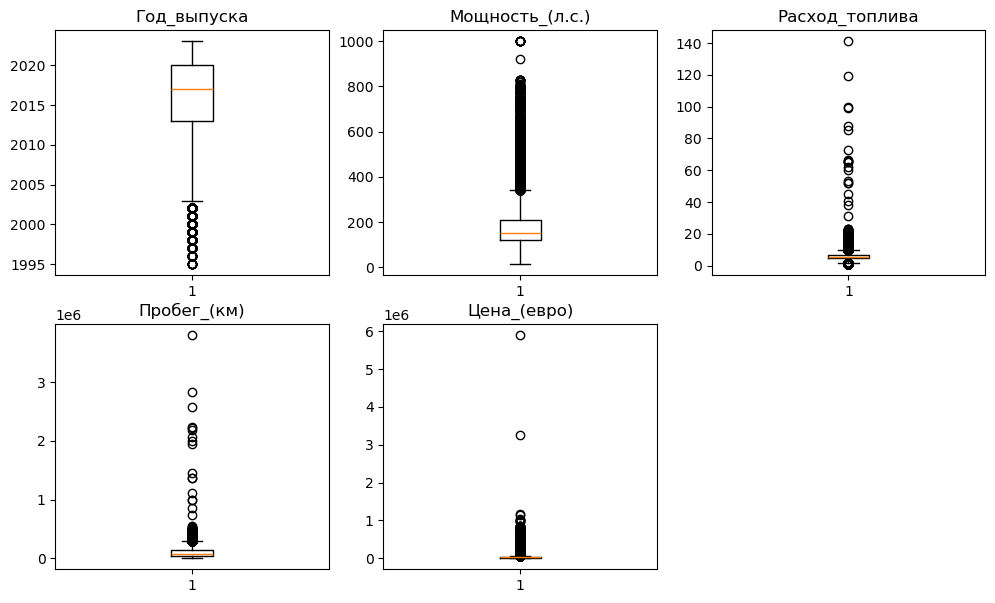

In [797]:
fig = plt.figure(figsize = (12,7))
for i, column in enumerate(df[["Год_выпуска", "Мощность_(л.с.)", "Расход_топлива", "Пробег_(км)", "Цена_(евро)"]]):
    fig.add_subplot(2, 3, i + 1)
    plt.boxplot(df[column])
    plt.title(column)

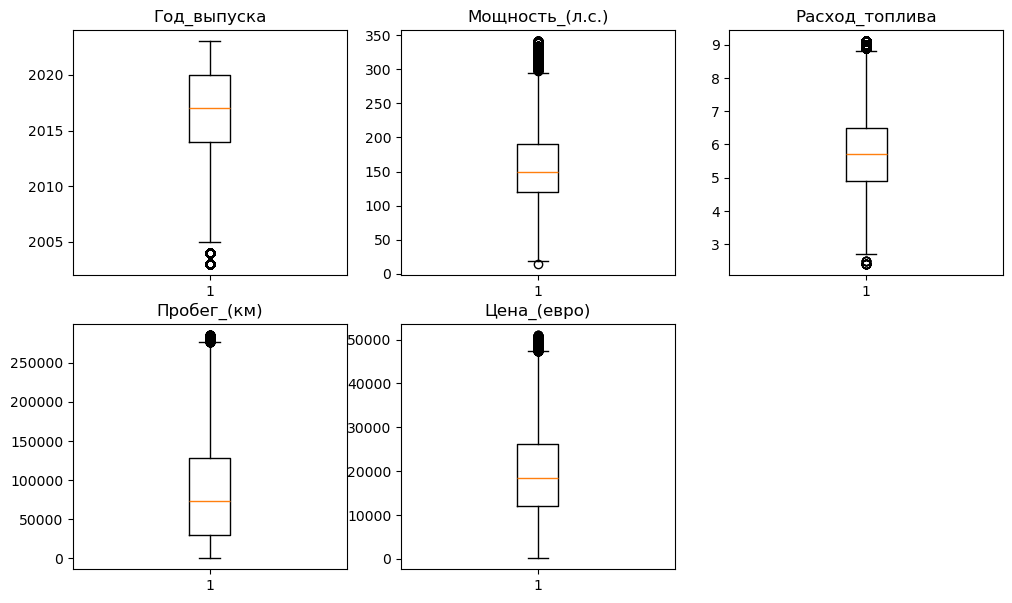

In [798]:
fig = plt.figure(figsize = (12,7))
for i, column in enumerate(df[["Год_выпуска", "Мощность_(л.с.)", "Расход_топлива", "Пробег_(км)", "Цена_(евро)"]]):
    Q1 = np.quantile(df[column], 0.25)
    Q3 = np.quantile(df[column], 0.75)
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR
    lower = Q1 - 1.5 * IQR
    df = df[(lower <= df[column]) & (df[column] <= upper)]
    fig.add_subplot(2, 3, i + 1)
    plt.boxplot(df[column])
    plt.title(column)

## 4 Обзор датафрейма

In [799]:
df.describe()

,Год_выпуска,Мощность_(л.с.),Расход_топлива,Пробег_(км),Цена_(евро)
count,71975.000000,71975.000000,71975.000000,71975.000000,71975.000000
mean,2016.366600,156.404724,5.757621,87996.670386,19929.160181
std,4.563847,59.828964,1.137448,67727.437044,10697.028802
min,2003.000000,14.000000,2.400000,0.000000,150.000000
25%,2014.000000,116.000000,4.900000,34000.000000,11998.000000
50%,2017.000000,150.000000,5.600000,76118.000000,18470.000000
75%,2019.000000,190.000000,6.400000,131500.000000,26188.000000
max,2023.000000,341.000000,9.100000,285100.000000,50940.000000


## 5. Визуализация данных

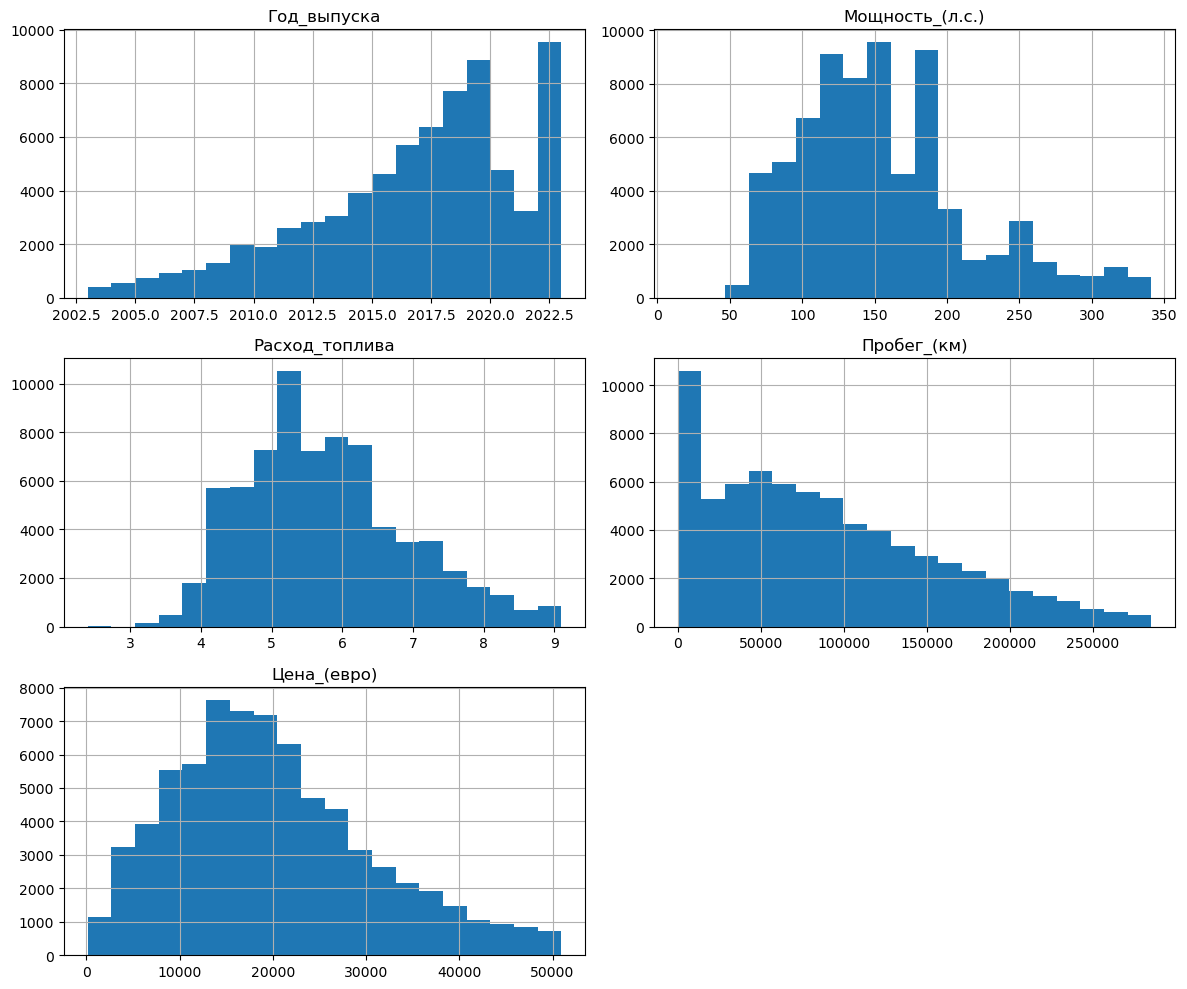

In [813]:
def hist_show(data, cols):
    data[cols].hist(bins=20, figsize = (12, 10))
    plt.tight_layout()
    plt.show()
hist_show(df, ["Год_выпуска", "Мощность_(л.с.)", "Расход_топлива", "Пробег_(км)", "Цена_(евро)"])

In [801]:
def categorical_show(data, cols):
    plt.figure(figsize=(8, 6))
    sns.countplot(data=data, x=cols, hue=cols, palette='pastel')
    plt.title(cols, fontsize = 16)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

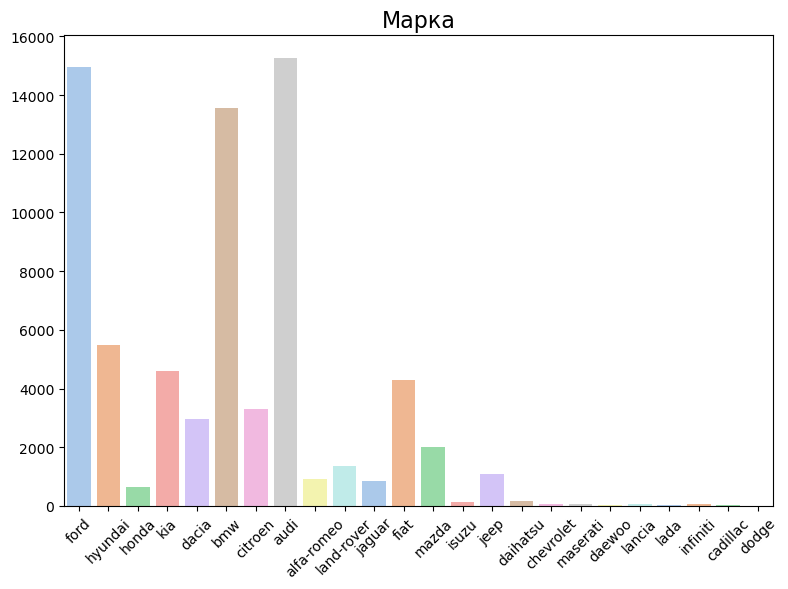

In [802]:
for col in ["Марка"]:
    categorical_show(df, col)

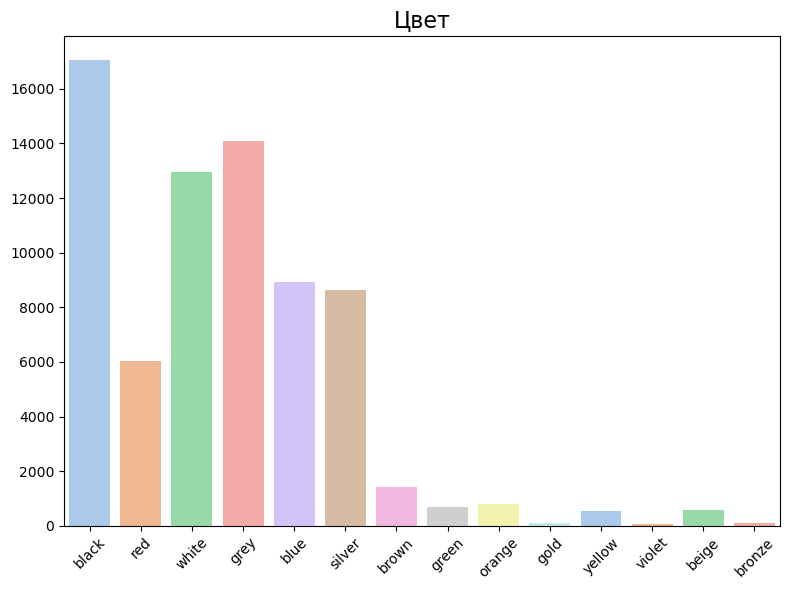

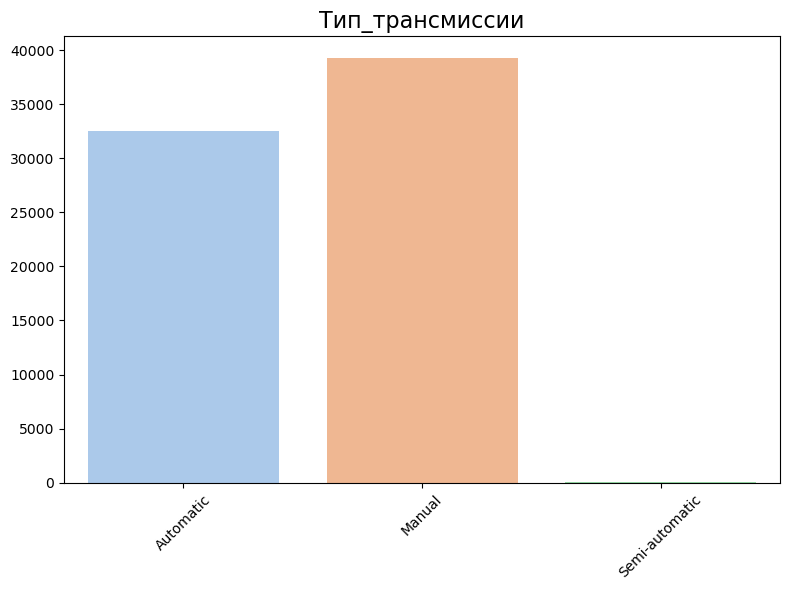

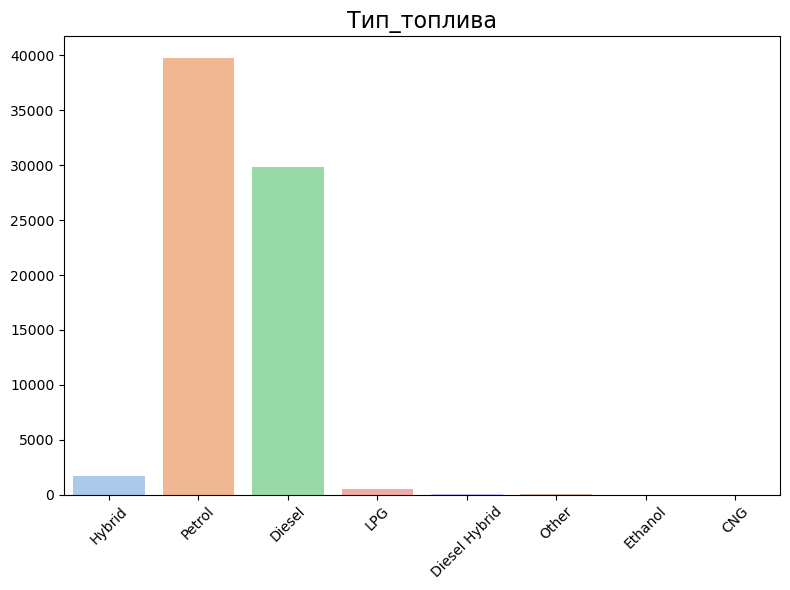

In [803]:
for col in ["Цвет", "Тип_трансмиссии", "Тип_топлива"]:
    categorical_show(df, col)

## 6. Преобразование категориальных данных

In [804]:
df = pd.get_dummies(df, columns=["Марка", "Модель", "Цвет", "Тип_трансмиссии", "Тип_топлива"], dtype=int)
df.head()

,Год_выпуска,Мощность_(л.с.),Расход_топлива,Пробег_(км),Цена_(евро),Марка_alfa-romeo,Марка_audi,Марка_bmw,Марка_cadillac,Марка_chevrolet,...,Тип_трансмиссии_Manual,Тип_трансмиссии_Semi-automatic,Тип_топлива_CNG,Тип_топлива_Diesel,Тип_топлива_Diesel Hybrid,Тип_топлива_Ethanol,Тип_топлива_Hybrid,Тип_топлива_LPG,Тип_топлива_Other,Тип_топлива_Petrol
0,2023,190,5.4,100,38490,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2018,67,4.6,27782,11555,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,2018,155,7.5,57000,24490,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2023,150,5.9,7500,34990,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
5,2009,140,6.7,160000,5800,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


## 7. Обучение моделей машинного обучения

In [805]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns = ["Цена_(евро)"]),
    df["Цена_(евро)"],
    test_size = 0.2,
    random_state = 100
)
model1 = LinearRegression()
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)

model2 = DecisionTreeRegressor()
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)

## 8. Оценка точности

In [806]:
mse1 = mean_squared_error(y_test, y_pred1)
mae1 = mean_absolute_error(y_test, y_pred1)
mse2 = mean_squared_error(y_test, y_pred2)
mae2 = mean_absolute_error(y_test, y_pred2)

In [807]:
model_metrics = pd.DataFrame({"LinearRegression": [mse1, mae1], "DecisionTreeRegressor": [mse2, mae2]}, index = ["MSE", "MAE"])
model_metrics

,LinearRegression,DecisionTreeRegressor
MSE,1.525191e+07,1.975272e+07
MAE,2.781435e+03,2.790912e+03


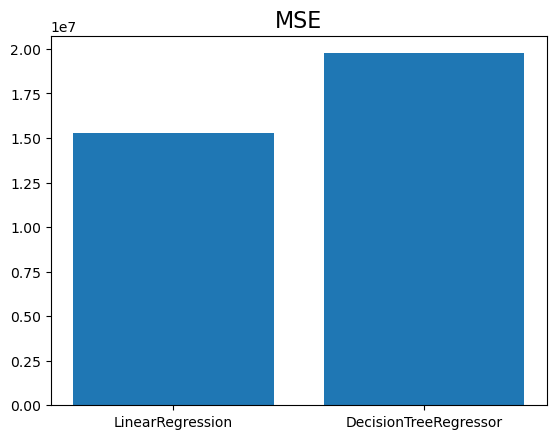

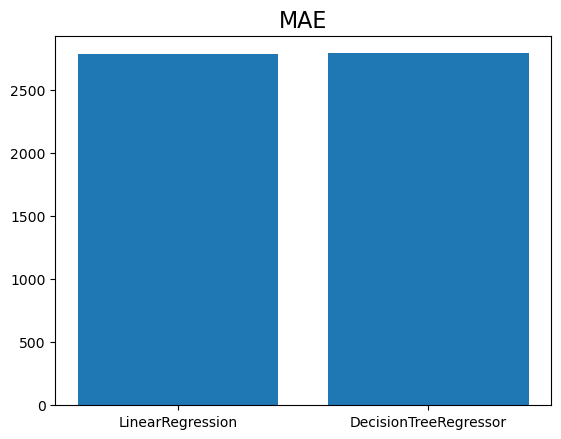

In [808]:
for index, row in model_metrics.iterrows():
    plt.bar(model_metrics.columns.tolist(), row)
    plt.title(index, fontsize = 16)
    plt.show()